In [272]:
%pip install pandas geopandas seaborn matplotlib scikit-learn esda splot folium libpysal numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [273]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np
from scipy import stats

In [274]:
# file defines and functions
def makeOutputDir(directory, baseDir='./outputs'):
    date = datetime.datetime.now().strftime("%Y%m%d")
    output_dir = f'{baseDir}/{date}/{directory}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    return output_dir

def check_missing_values(dataset):
    return dataset.isnull().sum().to_frame()

def replace_invalid_dates(date_str):
    # Split the date string into components
    parts = date_str.split('-')
    
    # Check if the year is valid
    if len(parts) < 1 or not parts[0].isdigit() or len(parts[0]) != 4:
        return pd.NaT  # Return Not a Time if year is invalid
    
    year = parts[0]
    
    # Check if the month is valid
    if len(parts) < 2 or not parts[1].isdigit() or not (1 <= int(parts[1]) <= 12):
        month = '01'  # Default to January if month is invalid
    else:
        month = parts[1].zfill(2)  # Ensure month is two digits
    
    # Check if the day is valid
    if len(parts) < 3 or not parts[2].isdigit() or not (1 <= int(parts[2]) <= 31):
        day = '01'  # Default to the first day of the month if day is invalid
    else:
        day = parts[2].zfill(2)  # Ensure day is two digits
    
    # Construct the valid date string
    valid_date_str = f"{year}-{month}-{day}"
    
    # Convert to datetime
    return pd.to_datetime(valid_date_str)


# Constants and Variables

In [275]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# constants
plot_title = "Country Mexico"
country_name = "Mexico"

dataset_file_name = "Mexico_wosis_merged.csv"
master_dataset_file_path = f"../outputs/{dataset_file_name}"

output_dir = makeOutputDir(country_name, "../outputs")
saveModelPath = makeOutputDir(country_name, "../test_models")

drop_columns = ['date', 'latitude', 'longitude', 'country_name', 'region', 'continent']

orgc_column = 'orgc_value'
tceq_column = 'tceq_value'
silt_column = 'silt_value'
clay_column = 'clay_value'


# model list
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor()
}

# -- do not change below this line --

---

# Load Dataset

Load master dataset

In [276]:
# load master dataset
master_dataset = pd.read_csv(master_dataset_file_path)

# replace invalid dates
master_dataset['date'] = master_dataset['date'].apply(replace_invalid_dates)

# Plot Missing Values

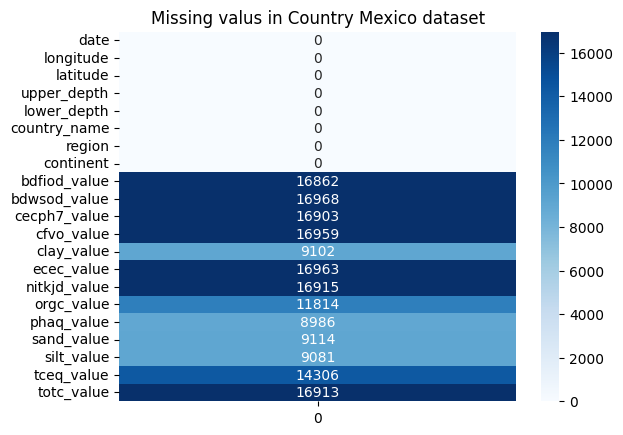

In [277]:
# plot missing values
missing_values = check_missing_values(master_dataset)
sns.heatmap(missing_values, annot=True, fmt='g', cmap='Blues')
plt.title(f"Missing valus in {plot_title} dataset")
plt.show()

# Remove missing values

- Removing the columns with missing values which are more than 90% of length of dataset

In [278]:
# remove missing columns with threshold
master_dataset = master_dataset.dropna(thresh=0.1 * len(master_dataset), axis=1)
print(f"master_dataset columns: {master_dataset.columns.tolist()}")

master_dataset columns: ['date', 'longitude', 'latitude', 'upper_depth', 'lower_depth', 'country_name', 'region', 'continent', 'clay_value', 'orgc_value', 'phaq_value', 'sand_value', 'silt_value', 'tceq_value']


# Feature Engineering
Create a  new column for Bulk Density, Organic Matter based on formulaes below

Create a new column for combination of silt_plus_clay

In [279]:
# Feature EngineeringCre   nw column for Bulk Densiy, O Mbnfmule below
master_dataset['organic_matter'] = master_dataset.apply(lambda row: 1.724 * row[orgc_column], axis=1)

# create bulk density
master_dataset[f'bulk_density'] = master_dataset.apply(lambda row: 1.62-0.06 * row['organic_matter'], axis=1)

# create sum of silt plus clay
master_dataset[f'silt_plus_clay'] = master_dataset.apply(lambda row: (row[silt_column] if not pd.isnull(row[silt_column]) else 0) + (row[clay_column] if not pd.isnull(row[clay_column]) else 0) , axis=1)

# drop silt and clay column
master_dataset = master_dataset.drop(columns=[silt_column, clay_column]).copy()

print(f"\n Length of dataset: {len(master_dataset)}")


 Length of dataset: 16977


# Removing Negative Values

In [280]:
# remove negative values ignore latitude and longitude
numeric_columns_dataset = master_dataset.select_dtypes(include=['int64', 'float64']).columns.difference(['latitude', 'longitude'])
# master_dataset = master_dataset[master_dataset[numeric_columns_dataset] >= 0]
# master_dataset = master_dataset[master_dataset[numeric_columns_dataset] >= 0]

print("Length of numeric columns:", len(numeric_columns_dataset))
print(numeric_columns_dataset)
master_dataset.head()

Length of numeric columns: 9
Index(['bulk_density', 'lower_depth', 'organic_matter', 'orgc_value',
       'phaq_value', 'sand_value', 'silt_plus_clay', 'tceq_value',
       'upper_depth'],
      dtype='object')


,date,longitude,latitude,upper_depth,lower_depth,country_name,region,continent,orgc_value,phaq_value,sand_value,tceq_value,organic_matter,bulk_density,silt_plus_clay
0,1900-01-01,-117.067005,32.381501,0,17,Mexico,Central America,Northern America,NaN,NaN,NaN,NaN,NaN,NaN,16.0
1,1900-01-01,-113.720733,28.398335,0,12,Mexico,Central America,Northern America,NaN,5.8,NaN,NaN,NaN,NaN,0.0
2,1900-01-01,-113.508035,26.811638,0,17,Mexico,Central America,Northern America,NaN,NaN,NaN,NaN,NaN,NaN,18.0
3,1900-01-01,-111.911887,30.057093,0,13,Mexico,Central America,Northern America,NaN,8.0,NaN,NaN,NaN,NaN,0.0
4,1900-01-01,-111.905165,31.480747,18,30,Mexico,Central America,Northern America,NaN,8.1,NaN,NaN,NaN,NaN,0.0


# Visualising distribution of data

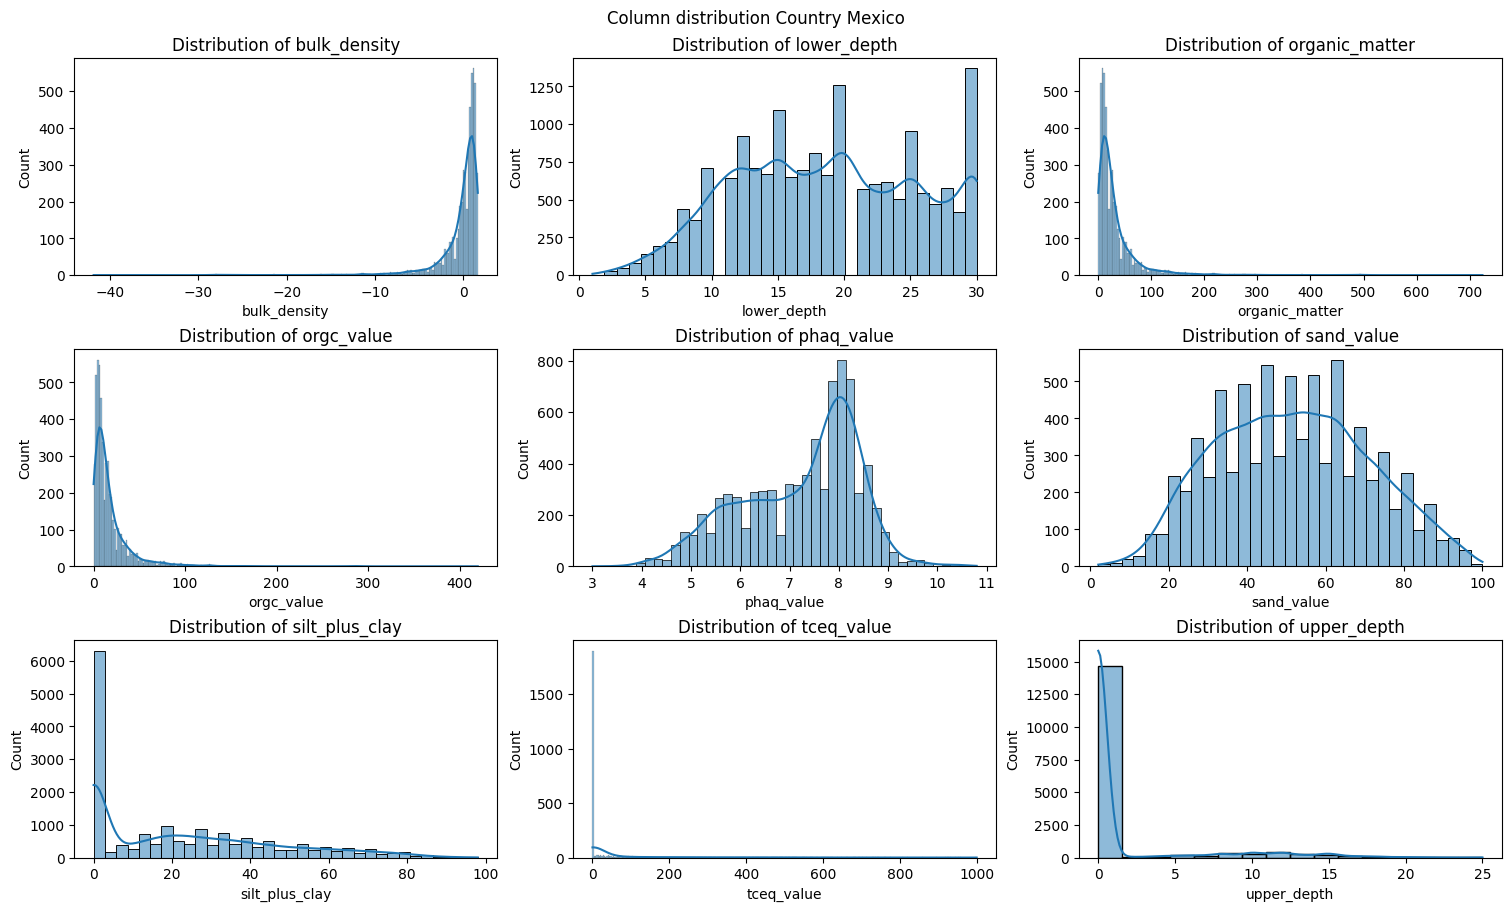

In [281]:
# Visualising data distribution
import math
def plot_distribution_charts(numeric_columns, dataset, title=""):
    num_cols = len(numeric_columns)

    # Define the number of rows and columns dynamically
    chart_cols = 3  # Fixed number of columns
    chart_rows = math.ceil(num_cols / chart_cols)  # Calculate required rows based on columns

    fig, axes = plt.subplots(chart_rows, chart_cols, figsize=(15, 3 * chart_rows), constrained_layout=True)
    axes = axes.flatten()  # Flatten the axes for easy iteration

    for i, col in enumerate(numeric_columns):
        sns.histplot(dataset[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Column distribution {title}")
    plt.show()

plot_distribution_charts(numeric_columns_dataset, master_dataset, plot_title)

# Removing Outliers using Z-Score

In [282]:
# remove outliers for orgc and tceq
for col in numeric_columns_dataset:
    # setting upper and lower limit
    upper_limit = master_dataset[col].mean() + 3*master_dataset[col].std()
    lower_limit = master_dataset[col].mean() - 3*master_dataset[col].std()

    # count outliers
    count_outliers = master_dataset[(master_dataset[col] > upper_limit) | (master_dataset[col] < lower_limit)]

    # trim outlier using z-score
    master_dataset = master_dataset[(master_dataset[col] >= lower_limit) & (master_dataset[col] <= upper_limit)]

    if(len(count_outliers) > 0):
        print(f"Processing column {col}")
        print("Upper limit",upper_limit, "Lower limit", lower_limit)
        print("Total Outliers", len(count_outliers))

print(f"\n Length of dataset: {len(master_dataset)}")
master_dataset.head()

Processing column bulk_density
Upper limit 8.094016522029024 Lower limit -8.696659255323619
Total Outliers 91
Processing column organic_matter
Upper limit 113.17979348955882 Lower limit -58.120495224574576
Total Outliers 136
Processing column orgc_value
Upper limit 52.9914265380803 Lower limit -24.527812275519516
Total Outliers 98
Processing column phaq_value
Upper limit 10.980884356313954 Lower limit 3.5984475852309306
Total Outliers 2
Processing column tceq_value
Upper limit 475.06627784755904 Lower limit -360.72909171762683
Total Outliers 77
Processing column upper_depth
Upper limit 16.789802438155974 Lower limit -12.258552438155975
Total Outliers 53

 Length of dataset: 2379


,date,longitude,latitude,upper_depth,lower_depth,country_name,region,continent,orgc_value,phaq_value,sand_value,tceq_value,organic_matter,bulk_density,silt_plus_clay
11537,1969-08-05,-101.483036,21.801816,0,15,Mexico,Central America,Northern America,4.0,6.2,62.0,0.0,6.896,1.20624,38.0
11538,1969-08-07,-101.552622,21.674967,0,30,Mexico,Central America,Northern America,10.0,6.4,58.0,0.0,17.240,0.58560,42.0
11539,1969-08-11,-100.462493,21.496251,0,15,Mexico,Central America,Northern America,26.0,6.3,44.0,0.0,44.824,-1.06944,56.0
11540,1969-08-15,-101.695887,21.741673,0,12,Mexico,Central America,Northern America,9.0,6.1,48.0,0.0,15.516,0.68904,52.0
11541,1969-08-15,-101.695887,21.741673,12,28,Mexico,Central America,Northern America,6.0,6.4,46.0,0.0,10.344,0.99936,54.0


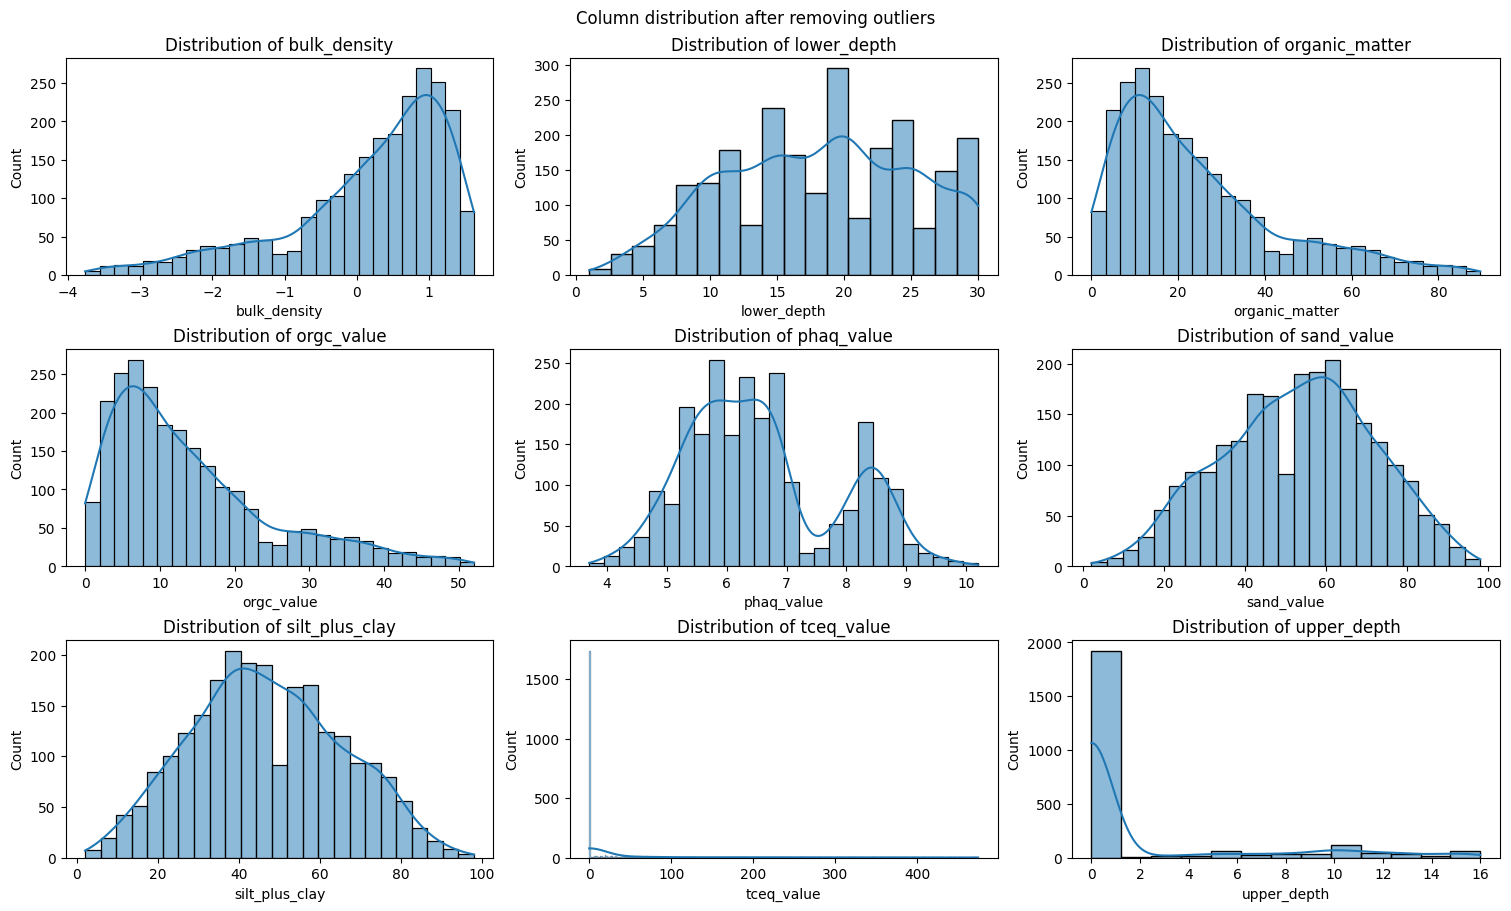

In [283]:
plot_distribution_charts(numeric_columns_dataset, master_dataset, "after removing outliers")

# Replacing Missing Values with avg of the column

In [284]:
# fill missing values with mean
master_dataset[numeric_columns_dataset] = master_dataset[numeric_columns_dataset].apply(lambda x: x.fillna(x.mean()), axis=0)
print(f"\n Length of dataset: {len(master_dataset)}")
master_dataset.head()


 Length of dataset: 2379


,date,longitude,latitude,upper_depth,lower_depth,country_name,region,continent,orgc_value,phaq_value,sand_value,tceq_value,organic_matter,bulk_density,silt_plus_clay
11537,1969-08-05,-101.483036,21.801816,0,15,Mexico,Central America,Northern America,4.0,6.2,62.0,0.0,6.896,1.20624,38.0
11538,1969-08-07,-101.552622,21.674967,0,30,Mexico,Central America,Northern America,10.0,6.4,58.0,0.0,17.240,0.58560,42.0
11539,1969-08-11,-100.462493,21.496251,0,15,Mexico,Central America,Northern America,26.0,6.3,44.0,0.0,44.824,-1.06944,56.0
11540,1969-08-15,-101.695887,21.741673,0,12,Mexico,Central America,Northern America,9.0,6.1,48.0,0.0,15.516,0.68904,52.0
11541,1969-08-15,-101.695887,21.741673,12,28,Mexico,Central America,Northern America,6.0,6.4,46.0,0.0,10.344,0.99936,54.0


# Dataset Length & Missing Values

orgc_df length: 2379
tceq_df length: 2379


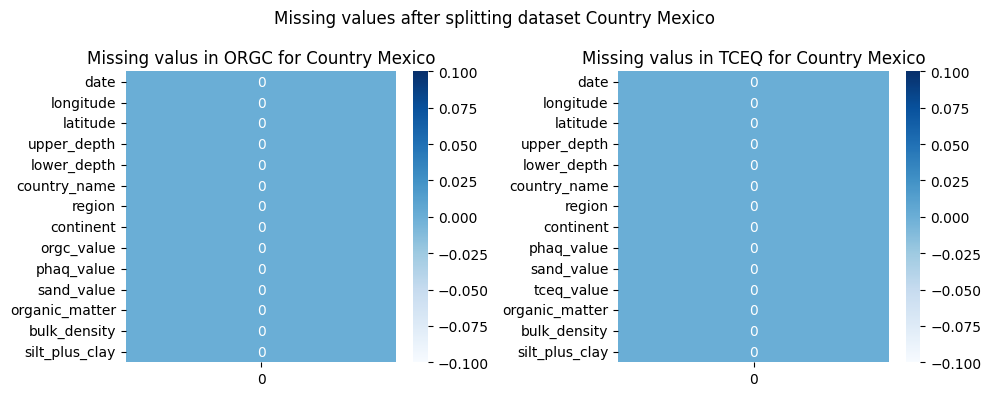

In [285]:
# split dataset into orgc and tceq
orgc_df = master_dataset.drop(columns=[tceq_column]).copy()
tceq_df = master_dataset.drop(columns=[orgc_column]).copy()

# count data & missing values
print(f"orgc_df length: {len(orgc_df)}")
print(f"tceq_df length: {len(tceq_df)}")

# plot missing values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
orgc_missing_values = check_missing_values(orgc_df)
sns.heatmap(orgc_missing_values, annot=True, fmt='g', cmap='Blues', ax=ax1)
ax1.set_title(f"Missing valus in ORGC for {plot_title}")

tceq_missing_values = check_missing_values(tceq_df)
sns.heatmap(tceq_missing_values, annot=True, fmt='g', cmap='Blues', ax=ax2)
ax2.set_title(f"Missing valus in TCEQ for {plot_title}")
plt.suptitle(f"Missing values after splitting dataset {plot_title}")
plt.tight_layout()
plt.show()

In [286]:
# save datasets
orgc_df.to_csv(f"{output_dir}/{country_name}_wosis_orgc.csv", index=False)
tceq_df.to_csv(f"{output_dir}/{country_name}_wosis_tceq.csv", index=False)

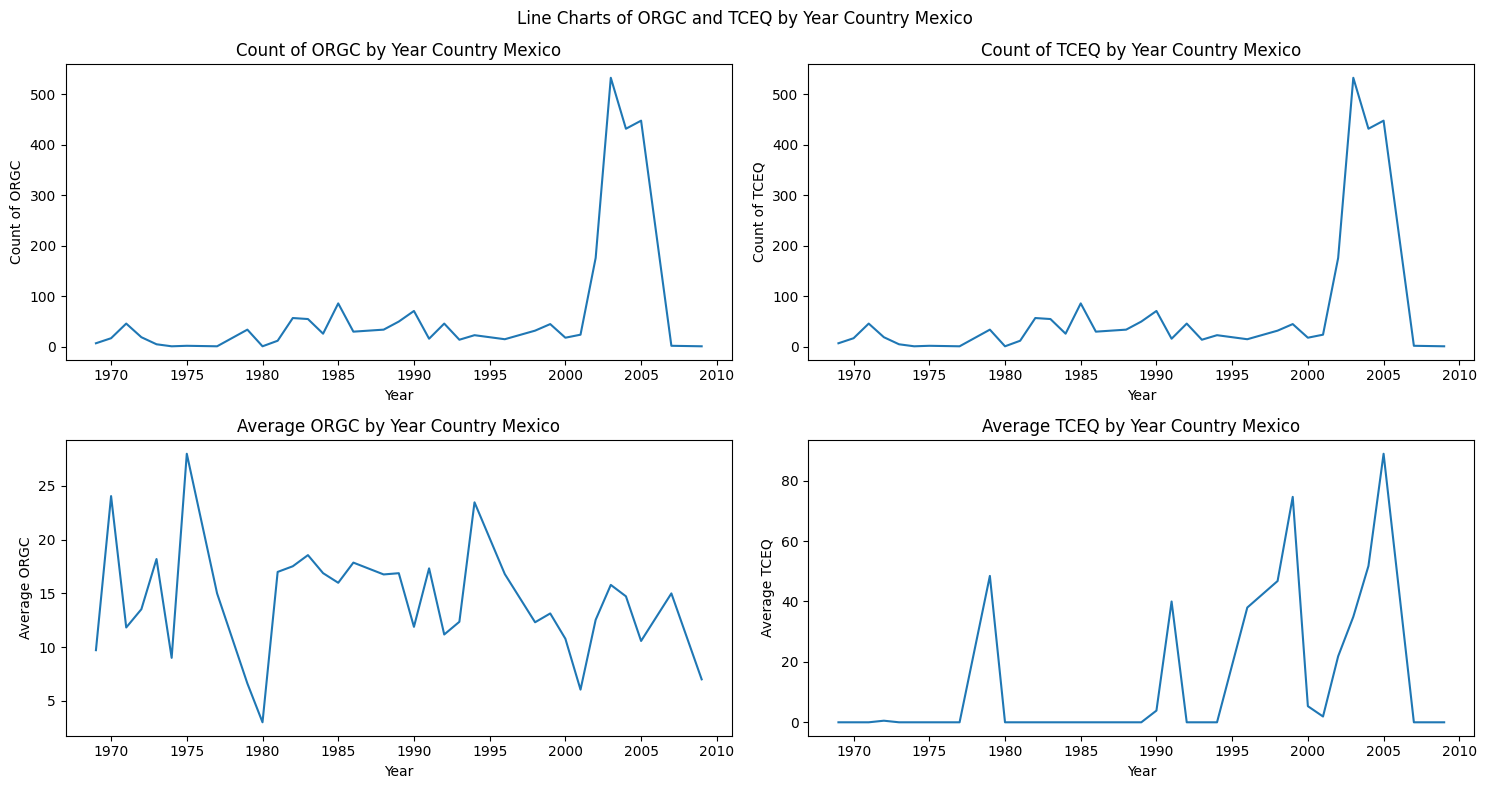

In [287]:
# plot line chart of orgc and tceq for each year
orgc_df['year'] = orgc_df['date'].dt.year
tceq_df['year'] = tceq_df['date'].dt.year

fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.lineplot(data=orgc_df.groupby('year')[orgc_column].count().reset_index(), x='year', y=orgc_column, ax=ax[0, 0])
ax[0, 0].set_title(f'Count of ORGC by Year {plot_title}')
ax[0, 0].set_xlabel('Year')
ax[0, 0].set_ylabel('Count of ORGC')

sns.lineplot(data=tceq_df.groupby('year')[tceq_column].count().reset_index(), x='year', y=tceq_column, ax=ax[0, 1])
ax[0, 1].set_title(f'Count of TCEQ by Year {plot_title}')
ax[0, 1].set_xlabel('Year')
ax[0, 1].set_ylabel('Count of TCEQ')

sns.lineplot(data=orgc_df.groupby('year')[orgc_column].mean().reset_index(), x='year', y=orgc_column, ax=ax[1, 0])
ax[1, 0].set_title(f'Average ORGC by Year {plot_title}')
ax[1, 0].set_xlabel('Year')
ax[1, 0].set_ylabel('Average ORGC')

sns.lineplot(data=tceq_df.groupby('year')[tceq_column].mean().reset_index(), x='year', y=tceq_column, ax=ax[1, 1])
ax[1, 1].set_title(f'Average TCEQ by Year {plot_title}')
ax[1, 1].set_xlabel('Year')
ax[1, 1].set_ylabel('Average TCEQ')

plt.suptitle(f'Line Charts of ORGC and TCEQ by Year {plot_title}')
plt.tight_layout()
plt.show()

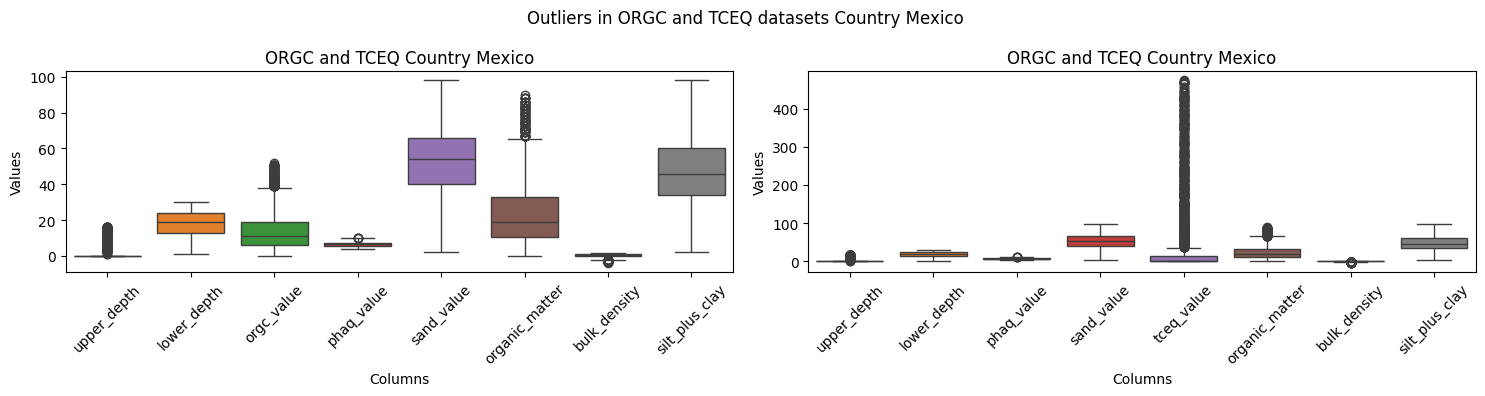

In [288]:
# outliers
def plot_outliers(dataframes, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    for i, dataframe in enumerate(dataframes):
        sns.boxplot(data=dataframe, ax=axes[i])
        axes[i].set_title(f'{title} {plot_title}')
        axes[i].set_xlabel('Columns')
        axes[i].set_ylabel('Values')
        axes[i].set_xticks(ticks=range(len(dataframe.columns)), labels=dataframe.columns, rotation=45)

    plt.suptitle(f'Outliers in ORGC and TCEQ datasets {plot_title}')
    plt.tight_layout()
    plt.show()


# Create copy of year column
orgc_year = orgc_df['year'].copy()
tceq_year = tceq_df['year'].copy()

# append to drop colum
drop_columns.append("year")

plot_outliers([orgc_df.drop(columns=drop_columns), tceq_df.drop(columns=drop_columns)], 'ORGC and TCEQ')

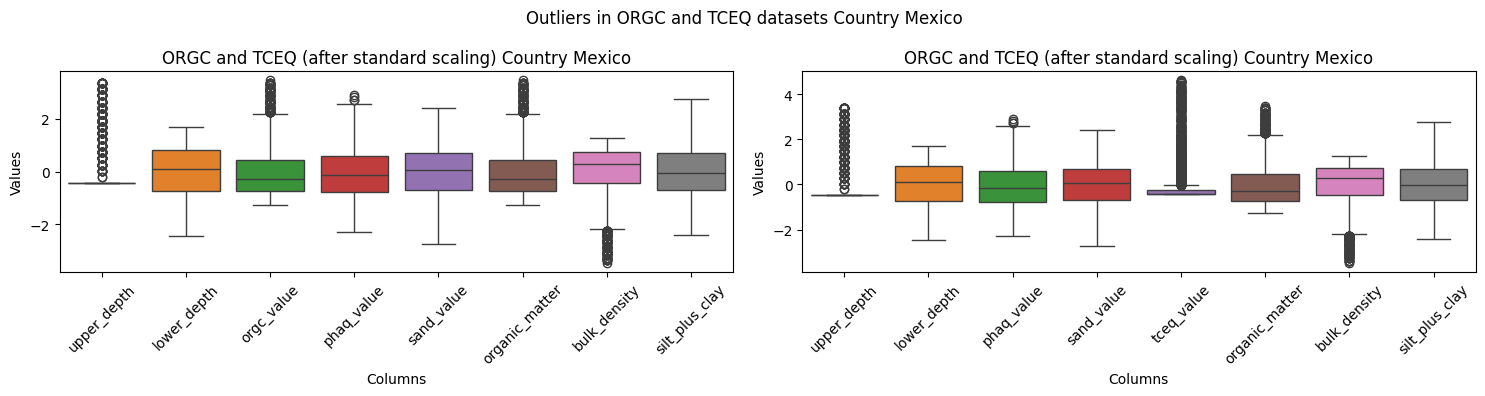

In [289]:
# Normalize data using standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
orgc_scaled = scaler.fit_transform(orgc_df.drop(columns=drop_columns))
standard_orgc_df = pd.DataFrame(orgc_scaled, columns=orgc_df.drop(columns=drop_columns).columns)

tceq_scaled = scaler.fit_transform(tceq_df.drop(columns=drop_columns))
standard_tceq_df = pd.DataFrame(tceq_scaled, columns=tceq_df.drop(columns=drop_columns).columns)

plot_outliers([standard_orgc_df, standard_tceq_df], 'ORGC and TCEQ (after standard scaling)')

# Add year column back to standardized dataframes
standard_orgc_df = standard_orgc_df.copy()
standard_tceq_df = standard_tceq_df.copy()
standard_orgc_df.loc[:, 'year'] = orgc_year.values
standard_tceq_df.loc[:, 'year'] = tceq_year.values

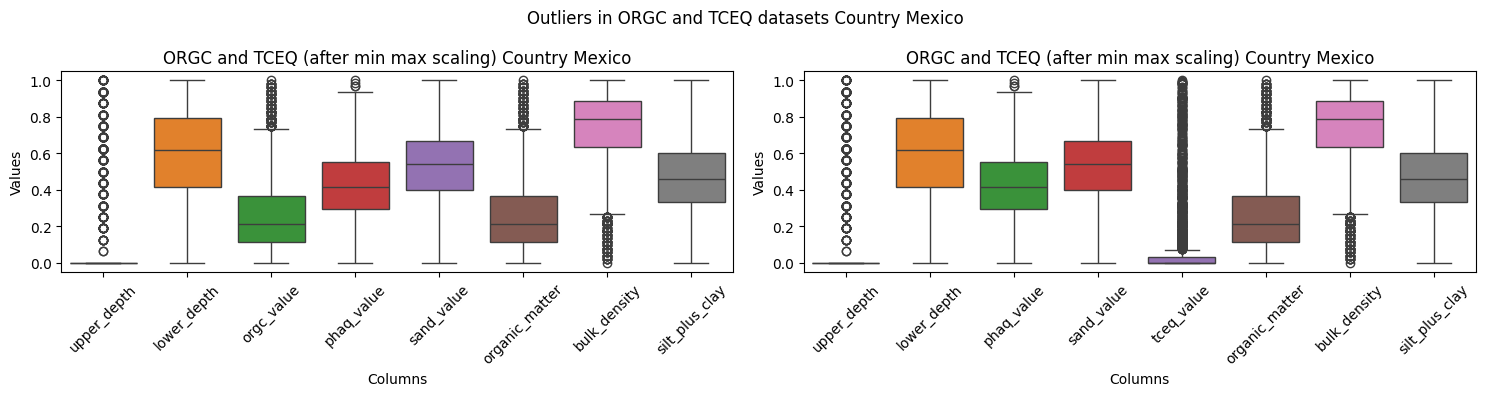

In [290]:
# normalize data using min max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
orgc_scaled_minmax = scaler.fit_transform(orgc_df.drop(columns=drop_columns))
minmax_orgc_df = pd.DataFrame(orgc_scaled_minmax, columns=orgc_df.drop(columns=drop_columns).columns)

tceq_scaled_minmax = scaler.fit_transform(tceq_df.drop(columns=drop_columns))
minmax_tceq_df = pd.DataFrame(tceq_scaled_minmax, columns=tceq_df.drop(columns=drop_columns).columns)

plot_outliers([minmax_orgc_df, minmax_tceq_df], 'ORGC and TCEQ (after min max scaling)')

minmax_orgc_df = minmax_orgc_df.copy()
minmax_tceq_df = minmax_tceq_df.copy()
minmax_orgc_df.loc[:, 'year'] = orgc_year.values
minmax_tceq_df.loc[:, 'year'] = tceq_year.values

# Confussion Matrix
Illustrate the relationship between features using confussion matrix

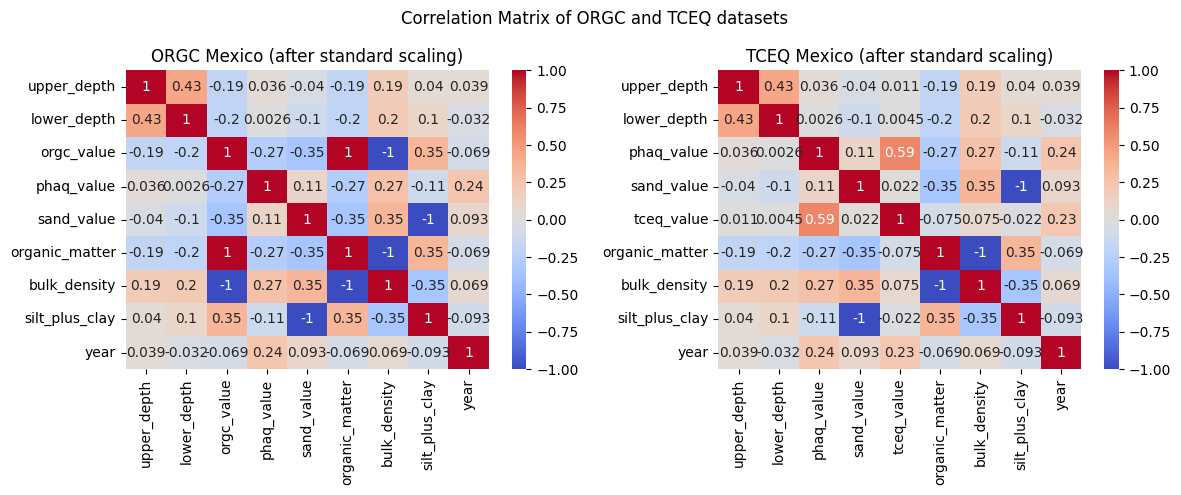

In [291]:
# correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

corr_matrix = standard_orgc_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title(f'ORGC {country_name} (after standard scaling)')

corr_matrix = standard_tceq_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title(f'TCEQ {country_name} (after standard scaling)')

plt.suptitle('Correlation Matrix of ORGC and TCEQ datasets')
plt.tight_layout()
plt.show()

# Traditional Model Training & Evaluation

In [292]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

def train_model(X, y, model):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # train the model
    model.fit(X_train, y_train)
    
    # evaluate the model
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2, y_test, y_pred

def validate_model(models, features, target, title, save_model=False):
    best_model = None
    best_model_score = float('inf')  # Initialize best model score as infinity

    # train the models
    fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
    print(title)
    for i, (model_name, model) in enumerate(models.items()):
        mse, mae, r2, y_test, y_pred = train_model(features, target, model)

        print(f'{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}')
        # joblib.dump(model, f'{saveModelPath}{title}_{model_name}.pkl')

        # Scatter plot of predicted vs actual
        axes[i].scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[i].set_title(f'{model_name}\n(MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f})', fontsize=10)
        axes[i].set_xlabel('Actual')
        axes[i].set_ylabel('Predicted')

        # Check if this model is better than the current best model
        if mae < best_model_score:
            best_model = model
            best_model_score = mae

    # Save the best model if specified
    if save_model and best_model:
        joblib.dump(best_model, f'{saveModelPath}/{title}_best_model.pkl')
        print("Best model saved in: ", f'{saveModelPath}/{title}_best_model.pkl')

    plt.suptitle(f'Scatter plots of {title} models')
    plt.tight_layout()
    plt.figtext(0.5, 0.005,
                'The scatter plots show the predicted vs actual values for each model. '
                'The red dashed line represents the perfect prediction.', 
                ha='center', fontsize=10)
    plt.show()

# Traning model on data from year 2000 onward

Mexico_ORGC
Random Forest Regressor - MSE: 5.804634702514952e-06, MAE: 0.0003589229706440521, R2: 0.9999941211987498
Gradient Boosting Regressor - MSE: 1.832075361864107e-07, MAE: 0.00013946290989502063, R2: 0.9999998144515981
Linear Regression - MSE: 5.6966580786919275e-31, MAE: 5.51005469589624e-16, R2: 1.0
Support Vector Regressor - MSE: 0.0065719718292203515, MAE: 0.05689802987575847, R2: 0.9933440572601193
K-Nearest Neighbors Regressor - MSE: 0.02126627789310672, MAE: 0.10851159577593122, R2: 0.9784620001994592
Best model saved in:  ../models/20250127/Mexico/Mexico_ORGC_best_model.pkl


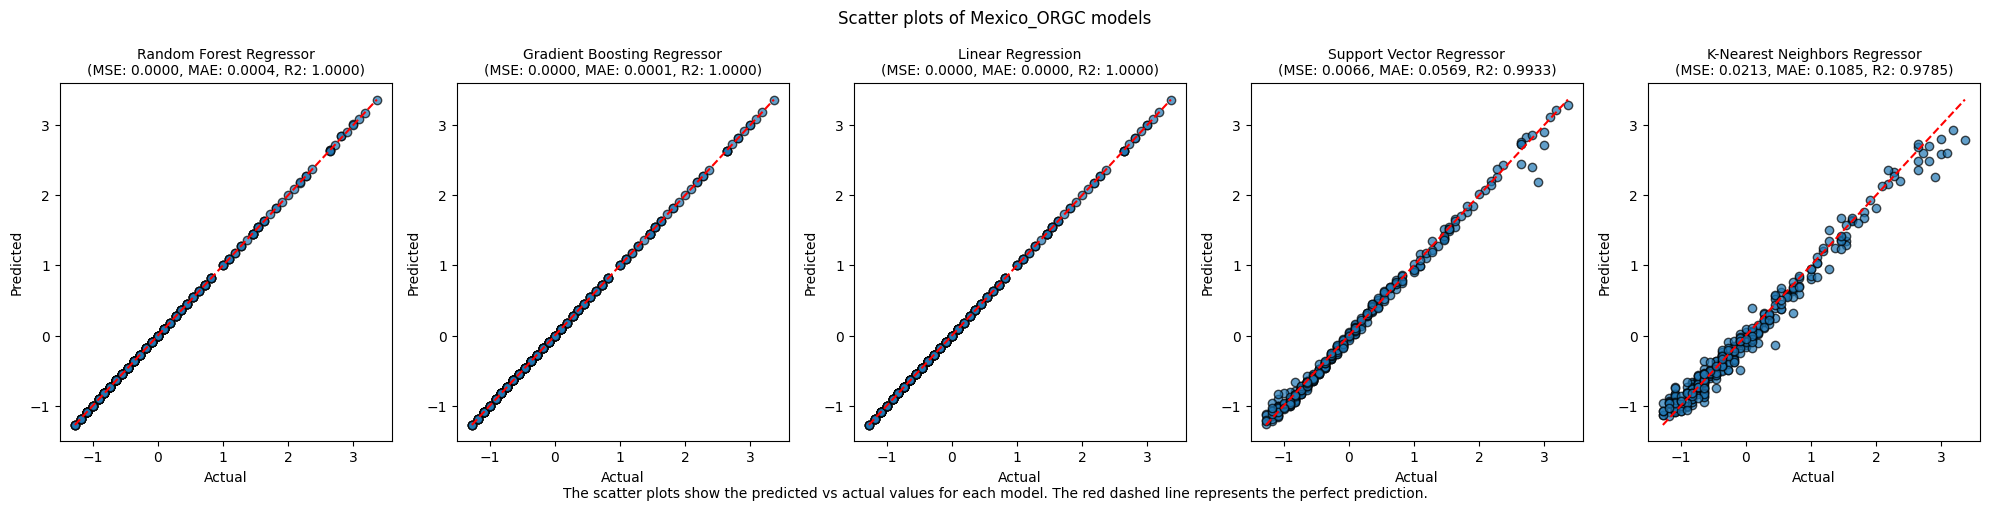

Mexico_TCEQ
Random Forest Regressor - MSE: 0.662212066897025, MAE: 0.39175926196815025, R2: 0.47950716924033465
Gradient Boosting Regressor - MSE: 0.5856497273963017, MAE: 0.37497611880348136, R2: 0.5396844912922307
Linear Regression - MSE: 0.7408512278364968, MAE: 0.5928691891442369, R2: 0.4176974838962658
Support Vector Regressor - MSE: 0.6443812609743121, MAE: 0.389924551906823, R2: 0.4935220250748512
K-Nearest Neighbors Regressor - MSE: 0.7315615495101687, MAE: 0.40360947154827537, R2: 0.4249990889418729
Best model saved in:  ../models/20250127/Mexico/Mexico_TCEQ_best_model.pkl


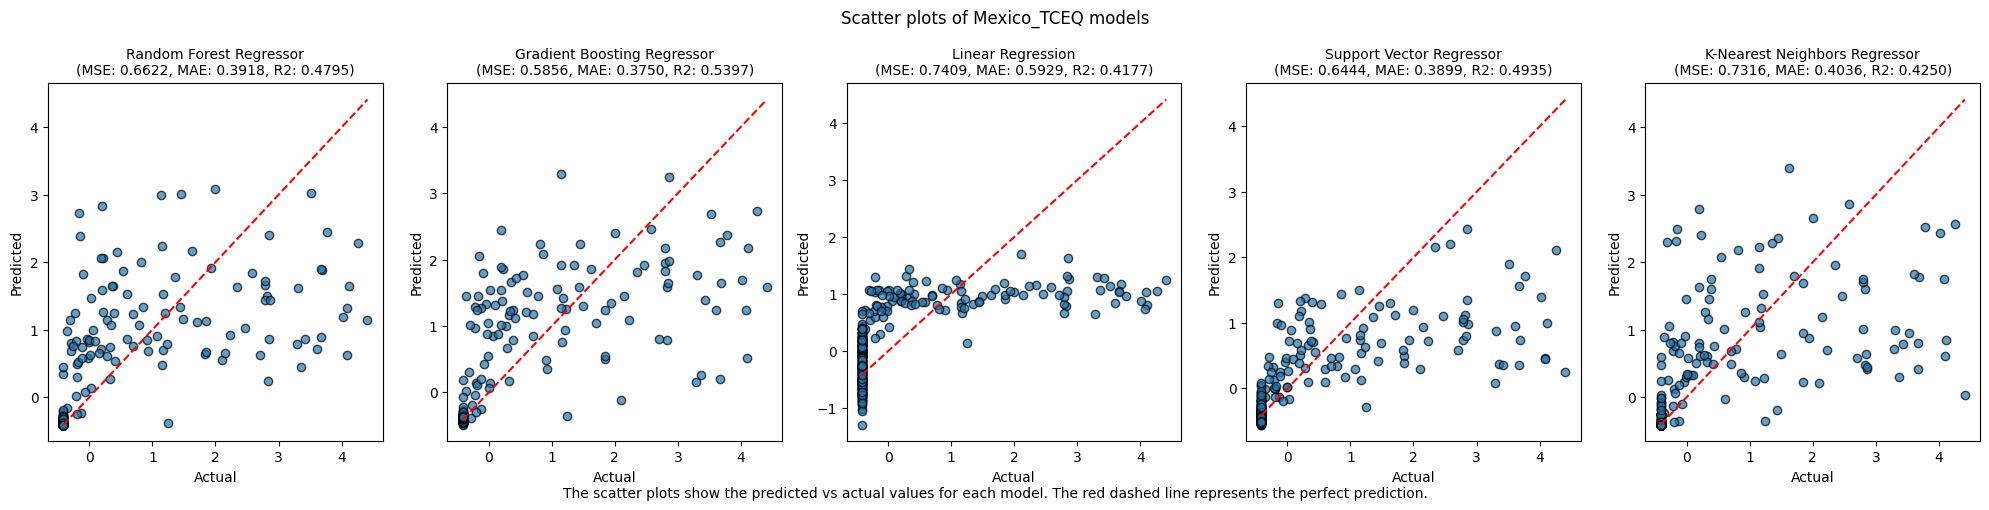

In [293]:
# Standard Scaled ORGC
orgc_year_2000 = standard_orgc_df[standard_orgc_df['year'] >= 2000].copy()
orgc_year_2000 = orgc_year_2000.drop(columns=['year'])
validate_model(models, orgc_year_2000.drop(columns=[orgc_column]), orgc_year_2000[orgc_column], f'{country_name}_ORGC', save_model=True)

# Standard Scaled TCEQ
tceq_year_2000 = standard_tceq_df[standard_tceq_df['year'] >= 2000].copy()
tceq_year_2000 = tceq_year_2000.drop(columns=['year'])
validate_model(models, tceq_year_2000.drop(columns=[tceq_column]), tceq_year_2000[tceq_column], f'{country_name}_TCEQ', save_model=True)

## Model Transferability to past data

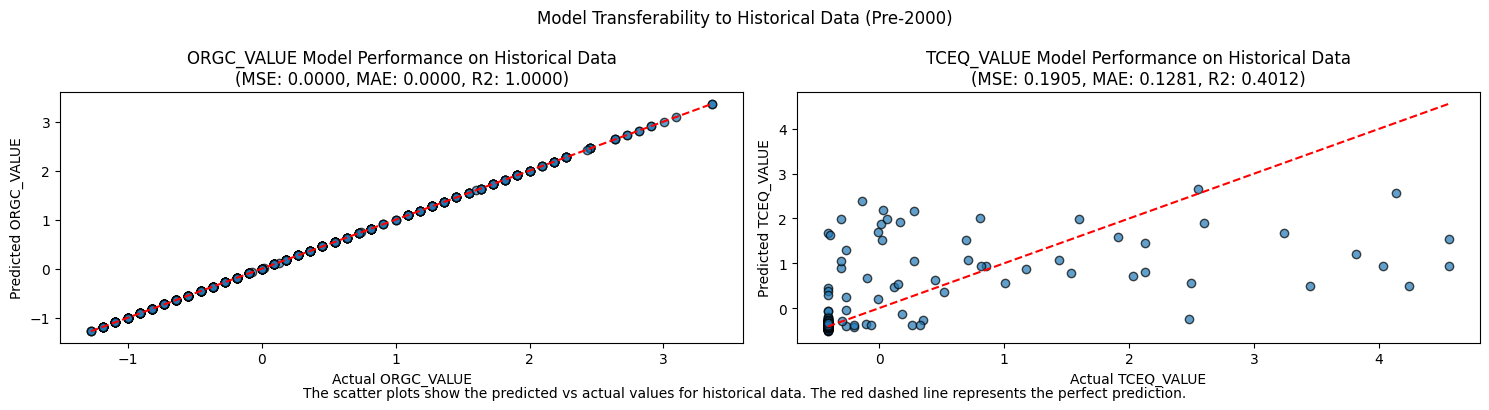

In [294]:
def plot_model_transferability(standard_df_dict, model_dict, saveModelPath, country_name):
    """
    Plot model transferability to historical data.
    
    Parameters:
    -----------
    standard_df_dict : dict
        Dictionary containing standardized dataframes for each target variable
        e.g. {'orgc': standard_orgc_df, 'tceq': standard_tceq_df}
    model_dict : dict 
        Dictionary containing trained models for each target variable
        e.g. {'orgc': orgc_model, 'tceq': tceq_model}
    saveModelPath : str
        Path where models are saved
    country_name : str
        Name of the country for which models were trained
        
    Returns:
    --------
    None. Displays plot comparing model performance on historical data.
    """
    
    fig, axes = plt.subplots(1, len(model_dict), figsize=(15, 4))
    
    for i, (target_var, model) in enumerate(model_dict.items()):
        # Get data for this target
        df = standard_df_dict[target_var]
        historical_data = df[df['year'] < 2000].copy()
        
        # Prepare features and target
        features = historical_data.drop(columns=['year', target_var])
        target = historical_data[target_var]
        
        # Make predictions
        predictions = model.predict(features)
        
        # Calculate metrics
        mse = mean_squared_error(target, predictions)
        mae = mean_absolute_error(target, predictions)
        r2 = r2_score(target, predictions)
        
        # Create scatter plot
        axes[i].scatter(target, predictions, alpha=0.7, edgecolors='k')
        axes[i].plot([target.min(), target.max()], [target.min(), target.max()], 'r--')
        axes[i].set_title(f'{target_var.upper()} Model Performance on Historical Data\n'
                         f'(MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f})')
        axes[i].set_xlabel(f'Actual {target_var.upper()}')
        axes[i].set_ylabel(f'Predicted {target_var.upper()}')

    plt.suptitle('Model Transferability to Historical Data (Pre-2000)')
    plt.tight_layout()
    plt.figtext(0.5, 0.01,
                'The scatter plots show the predicted vs actual values for historical data. '
                'The red dashed line represents the perfect prediction.',
                ha='center', fontsize=10)
    plt.show()


standard_df_dict = {
    orgc_column: standard_orgc_df,
    tceq_column: standard_tceq_df
}

model_dict = {
    orgc_column: joblib.load(f'{saveModelPath}/{country_name}_ORGC_best_model.pkl'),
    tceq_column: joblib.load(f'{saveModelPath}/{country_name}_TCEQ_best_model.pkl')
}

plot_model_transferability(standard_df_dict, model_dict, saveModelPath, country_name)

## Parameter Optimization


# Deep Learning Model Training & Evaluation


In [295]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [296]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [297]:
def split_and_scale(featurs, target, test_size=0.2, random_state=42):
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(featurs, target, test_size=test_size, random_state=random_state)

    # scaling for models like SVR and KNN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Use Input to specify the input shape
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def validate_dl_model(features, target, title, random_state=42, validation_split=0.2, epochs=100, batch_size=32, verbose=0):
    X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test = split_and_scale(features, target, test_size=validation_split, random_state=random_state)

    # initialise and train
    input_dim = X_train_scaled.shape[1]
    model = build_model(input_dim)
    history = model.fit(X_train_scaled, y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Evaluate on test data
    y_pred = model.predict(X_test_scaled).flatten()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Deep Learning Model - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    
    # Check for overfitting/underfitting
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    if val_loss > train_loss * 1.1:  # 10% threshold
        print("Model shows signs of overfitting (validation loss notably higher than training loss)")
    elif val_loss < train_loss * 0.9:  # 10% threshold
        print("Model shows signs of underfitting (validation loss notably lower than training loss)")
    else:
        print("Model shows good fit (validation and training losses are close)")

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Deep Learning Model {title} \nSplit: {validation_split} \nMSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    plt.show()

In [298]:
num_cols = numeric_columns_dataset.difference([tceq_column, orgc_column])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Deep Learning Model - MSE: 5.2127, MAE: 1.4318, R2: 0.9631
Model shows signs of overfitting (validation loss notably higher than training loss)


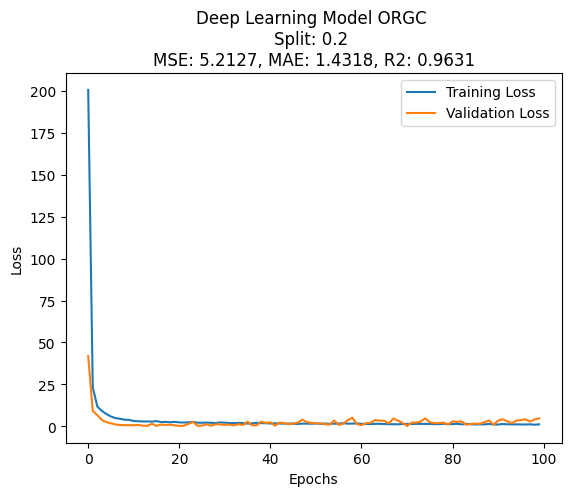

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Deep Learning Model - MSE: 4298.7414, MAE: 27.1361, R2: 0.3936
Model shows signs of underfitting (validation loss notably lower than training loss)


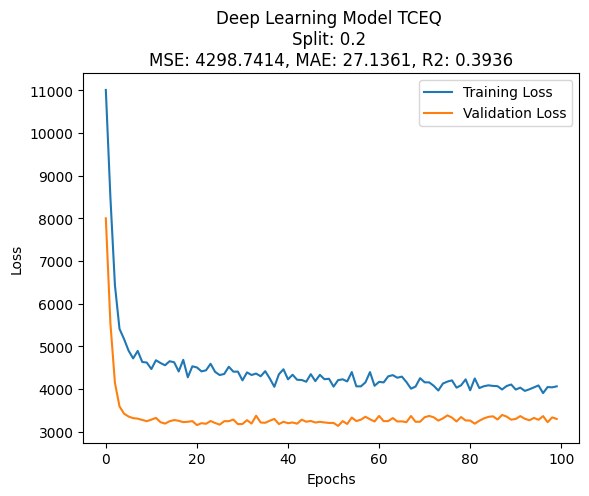

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Deep Learning Model - MSE: 1.3449, MAE: 0.7224, R2: 0.9896
Model shows good fit (validation and training losses are close)


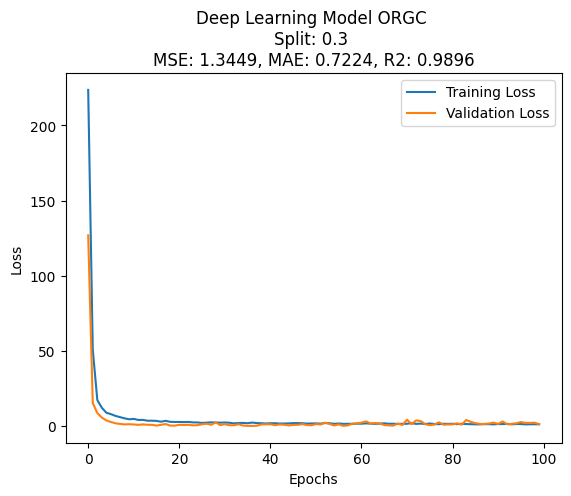

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Deep Learning Model - MSE: 4098.7323, MAE: 25.9451, R2: 0.4565
Model shows good fit (validation and training losses are close)


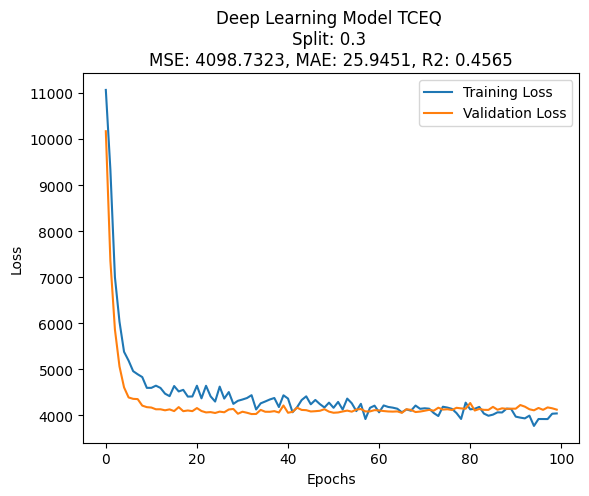

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Deep Learning Model - MSE: 4.6707, MAE: 1.3123, R2: 0.9619
Model shows signs of overfitting (validation loss notably higher than training loss)


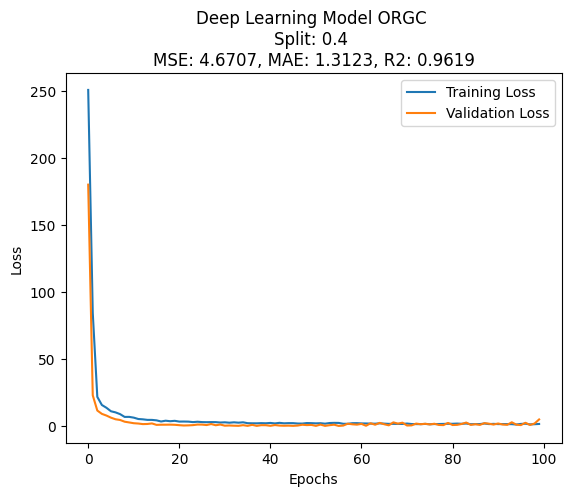

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Deep Learning Model - MSE: 4350.3722, MAE: 26.2074, R2: 0.4565
Model shows signs of overfitting (validation loss notably higher than training loss)


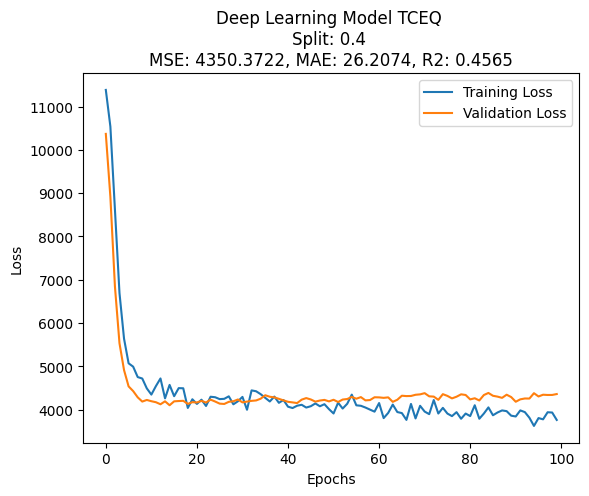

In [299]:
various_splits = [0.2, 0.3, 0.4]

for split_num in various_splits:
    # deep learning Orgc
    validate_dl_model(orgc_df[num_cols], orgc_df[orgc_column], title="ORGC", validation_split=split_num)

    # deep learning Tceq
    validate_dl_model(tceq_df[num_cols], tceq_df[tceq_column], title="TCEQ", validation_split=split_num)

# Spatial Regression

### Spatial Feature Engineering